<center><h1> Agent-Based Model of Panic</h1> </center>

## Imports

In [1]:
from copy import deepcopy
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statistics
import numpy as np
import pyabc
import seaborn as sns
from pyabc.transition.multivariatenormal import  MultivariateNormalTransition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import combinations
import plotly
import plotly.graph_objs as go

random.seed(1234)

## Model Class

In [30]:
class Model():

    def __init__(self, num_of_agents=10, num_iterations=10, mode ='heterogeneous', verbose=False):
        self.num_of_agents = num_of_agents
        self.num_iterations = num_iterations
        self.mode = mode
        self.verbose = verbose
        
        #parameter values
        self.beta = 0.1
        self.alpha = 0.1
        self.gamma = 0.1
        self.value = 1.5 
        self.time = 0 #model time
        
        
        #creating lists
        self.num_infected_per_iteration = list()
        self.num_infected_per_iteration_0 = list()
        self.num_infected_per_iteration_1 = list()       
        self.infected_agents = list() 
        self.num_of_infected = 0

        
        #create the agents
        self.agents = []
        for i in range(num_of_agents):
            # adding each new created agent to a list
            if self.mode == 'homogeneous' or 'heterogeneous':
                self.agents.append(Agent(self))
                
        #dividing populations into subgroups
        param_vals = (0.05, 0.6) #setting beta values for all subgroups
        self.n_groups = len(param_vals) #number of subgroups
        
        self.agent_groups = [list() for _ in range(self.n_groups)] #creating a list witin list of number of subgroups
        
        for i, agent in enumerate(self.agents):
            self.group_number = i % self.n_groups
            self.agent_groups[self.group_number].append(agent)
        
        for i, pv in enumerate(param_vals):
            for agent in self.agent_groups[i]:
                pv = self.beta
                
        # if the model hasn't finished running yet
        self.model_finished = False 

    
    def get_num_infected(self):
        #gets number of agents that are infected
        return len(([ a for a in self.agents if a.state==1 ]))

    def get_num_infected_1(self):
        #gets number of agents that are infected
        return len(([ a for a in self.agent_groups[1] if a.state==1 ]))

    
    def run(self):
        for t in range(self.num_iterations):
            for agent in self.agents:
                agent.step()
            
            if self.verbose:
                for i, agent in enumerate(self.agents):
                    print('Agent {0}/{1}:'.format(i, self.num_of_agents))    
                    if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                        print('my likelihood:{}, my state:{}'.format( agent.likelihood, agent.state))
            
            self.num_infected_per_iteration_0.append(self.get_num_infected())
            self.num_infected_per_iteration_1.append(self.get_num_infected_1())
                                                          
            if self.verbose:
                if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                    print('step: {},  total infected:{}'.format(t, self.get_num_infected()))
    
            #step time
            self.time += 1
            
        infected_agents = list()
        
        for agent in self.agents:
            if agent.state == 1:
                infected_agents.append(agent)
        self.num_of_infected = len(infected_agents)
        self.infected_agents.append(self.num_of_infected)
            
        #once each iteration is done, model is finished
        self.model_finished = True 


    def graph_num_infected(self):
        """
        Uses matplotlib to create a graph
        """
        if not self.model_finished:
            print("Can't print the number of infected until the model has finished")
            return
        
        # Create a figure and an axis (if you want more than one plot in the same
        # figure you can adjust the subplots function)
        
        fig, ax = plt.subplots(num=None, figsize=(5, 3), dpi=128, facecolor='w', edgecolor='k')
        
        # Do a scatter plot
        if self.mode == 'homogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration],
                    c="#5FC6CA", label=" Total infected") 
            
        if self.mode == 'heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration_0], 
                    [i for i in self.num_infected_per_iteration_1], label=" Total infected") 
        
        ax.set_title("Number of Infected per Iteration")
        ax.set_ylim(0,len(self.agents)) # limit the y axis
        ax.set_xlabel("Iteration (time)")
        ax.set_ylabel("Number of Panicked (Infected) Agents")
        ax.legend(loc='upper left')
        
        plt.savefig("Number of Infected Agents Through Time - 1000 ", bbox_inches="tight")

## Agent Class

In [31]:
class Agent():
    
    def __init__(self, model, alpha = 0.1, beta = 0.1, gamma= 0.1):
        #intialising parameters
        self.state = 0
        model.alpha = alpha
        model.gamma = gamma
        model.beta = beta 
        self.likelihood = 0

        #pointer to the model class
        self.model = model


    def step(self):
        if self.state == 0: 
            self.homogeneous_model()
            self.heterogeneous_model()

        else:
            self.recover()
          
        
    def homogeneous_model(self):
        Agent_i = random.choice(model.agents)
        
        if Agent_i.state == 1:
            self.likelihood = model.alpha + model.beta
        else:
            self.likelihood = model.alpha
        
        r = random.random()
        if r < self.likelihood: 
            self.state = 1

    def heterogeneous_model(self):
        if model.mode == ['heterogeneous']:
            
            agent_0 = random.choice(model.agent_groups[0])
            agent_1 = random.choice(model.agent_groups[1])

            
            if self in model.agent_groups[0]:
                if agent_0.state == 1:
                    self.likelihood = self.model.alpha + model.beta
                if agent_0.state == 0:
                    self.likelihood = self.model.alpha
            
            if self in model.agent_groups[1]:
                if agent_1.state == 1:
                    self.likelihood = self.model.alpha + model.beta
                if agent_1.state == 0:
                    self.likelihood = self.model.alpha
        
            r = random.random()
            if r < self.likelihood: 
                self.state = 1

#     def other_agents(self):
#         if model.num_of_infected > model.num_of_agents/model.value:
#             self.state = 1
    
    def recover(self):
        r1 = random.random()
        if self.state == 1:
            if r1 < model.gamma:
                self.state = 0

## Running model

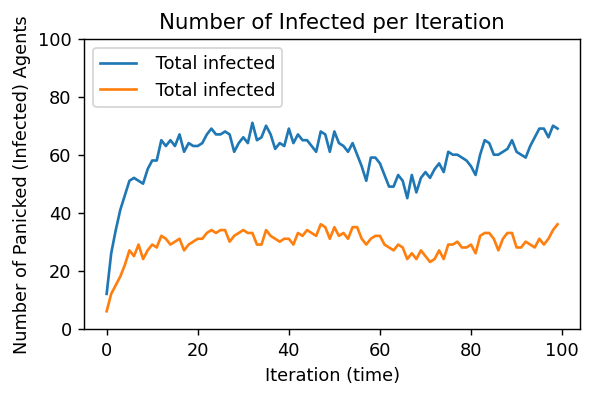

In [32]:
model = Model(num_of_agents=100, num_iterations=100, mode = 'heterogeneous')
model.run()
model.graph_num_infected()